# 导包

导入所需的依赖包：标准库、第三方库、自定义库

In [65]:
# 标准库
import os
import sys

# 第三方库
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as SSIM

# 自定义库
from src.core.Encoder import JP2KEncoder as MYJPEncoder
from src.core.Decoder import JP2KDecoder as MYJPDecoder

from src.config_.path_config import SRC_IMG_ROOT, ENCODED_IMG_ROOT, DECODED_IMG_ROOT


# 一、定义评价指标计算函数

主要评价指标包括PSNR和SSMI值，计算bpp用于绘制PSNR-bpp和SSMI-bpp图。

In [66]:
def psnr(src_img, decoded_img, color=False):
    if color:
        mse = mse = np.mean((src_img - decoded_img) ** 2, axis=(0, 1))
    else:
        mse = np.mean((src_img - decoded_img) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    psnr_value = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr_value

def ssim(src_img, decoded_img, win_size=7, multichannel=False):
    ssim_value = SSIM(src_img, decoded_img, win_size=win_size, multichannel=multichannel)
    return ssim_value

def bpp(file_size, image_size):
    h, w = image_size
    bpp_value = file_size / (h * w)
    return bpp_value

# 二、从kodok数据集计算绘图数据

1. 求出每张图的压缩后的psnr值、ssmi值，然后求平均值
2. 记录每张图求值时对应的bpp，便于绘制图像

In [67]:
def calculate(img_path, q_factor_list, encoder=None, decoder=None):
    if encoder is None:
        encoder = MYJPEncoder()
    if decoder is None:
        decoder = MYJPDecoder()
    bpp_list = []
    psnr_list = []
    ssim_list = []
    for q_factor in q_factor_list:
        encoder.q_factor = q_factor
        decoder.q_factor = q_factor

        src_img = encoder.read(img_path)
        src_bitstream = encoder.encode(src_img)
        decoded_img = decoder.decode(src_bitstream)

        if src_img.shape[0] != decoded_img.shape[0]:
            decoded_img = np.transpose(decoded_img, (1, 0, 2))

        src_gray_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)
        decoded_gray_img = cv2.cvtColor(decoded_img, cv2.COLOR_BGR2GRAY)

        psnr_value = psnr(src_gray_img, decoded_gray_img)
        psnr_list.append(psnr_value)
        ssim_value = ssim(src_gray_img, decoded_gray_img)
        ssim_list.append(ssim_value)
        file_size = sys.getsizeof(src_bitstream)
        bpp_value = bpp(file_size, decoded_img.shape[:2])
        bpp_list.append(bpp_value)
    return bpp_list, psnr_list, ssim_list

def calculate_jpeg(img_path, quality_list):
    bpp_list = []
    psnr_list = []
    ssim_list = []
    for quality in quality_list:
        src_img = Image.open(str(img_path))
        output_path = img_path.parent.parent.parent / "test_img" / f"{img_path.stem}.jpg"
        src_img.save(output_path, 'JPEG', quality=quality)

        src_img = cv2.imread(img_path)
        decoded_img = cv2.imread(output_path)
        
        src_gray_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)
        decoded_gray_img = cv2.cvtColor(decoded_img, cv2.COLOR_BGR2GRAY)
        
        psnr_value = psnr(src_gray_img, decoded_gray_img)
        psnr_list.append(psnr_value)
        ssim_value = ssim(src_gray_img, decoded_gray_img)
        ssim_list.append(ssim_value)
        file_size = os.path.getsize(output_path) * 8
        bpp_value = bpp(file_size, decoded_img.shape[:2])
        bpp_list.append(bpp_value)
    return bpp_list, psnr_list, ssim_list

# 三、根据数据绘制PSNR-bpp图和SSIM-bpp图

In [68]:
def draw_psnr(psnr_list, bpp_list,
              psnr_list_2=None, bpp_list_2=None, 
              title='PSNR vs. bpp', 
              xlabel='Bits per pixel (bpp)', 
              ylabel='PSNR (dB)', 
              xlim=None, 
              ylim=None):
    plt.figure(figsize=(10, 6))
    plt.plot(bpp_list, psnr_list, marker='o', color='b')
    if psnr_list_2 is not None and bpp_list_2 is not None:
        plt.plot(bpp_list_2, psnr_list_2, marker='s', color='r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid(True)
    plt.show()

def draw_ssim(ssim_list, bpp_list,
              ssim_list_2=None, bpp_list_2=None,
              title='SSIM vs. bpp', 
              xlabel='Bits per pixel (bpp)', 
              ylabel='SSIM', 
              xlim=None, 
              ylim=None):
    plt.figure(figsize=(10, 6))
    plt.plot(bpp_list, ssim_list, marker='o', color='b')
    if ssim_list_2 is not None and bpp_list_2 is not None:
        plt.plot(bpp_list_2, ssim_list_2, marker='s', color='r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid(True)
    plt.show()

In [69]:
KODOK_ROOT = SRC_IMG_ROOT / "kodok"

kodok_list = os.listdir(KODOK_ROOT)
kodok_list = [KODOK_ROOT / filename for filename in kodok_list]

encoder = MYJPEncoder(tile_size=128)
decoder = MYJPDecoder(tile_size=128)

# factor_list = range(10, 80, 10)
factor_list = [10, 20, 30, 60]
quality_list = range(10, 100, 10)

base_img = kodok_list[1]
bpp_list, psnr_list, ssim_list = calculate(base_img, factor_list, encoder, decoder)
jpeg_bpp_list, jpeg_psnr_list, jpeg_ssim_list = calculate_jpeg(base_img, quality_list)


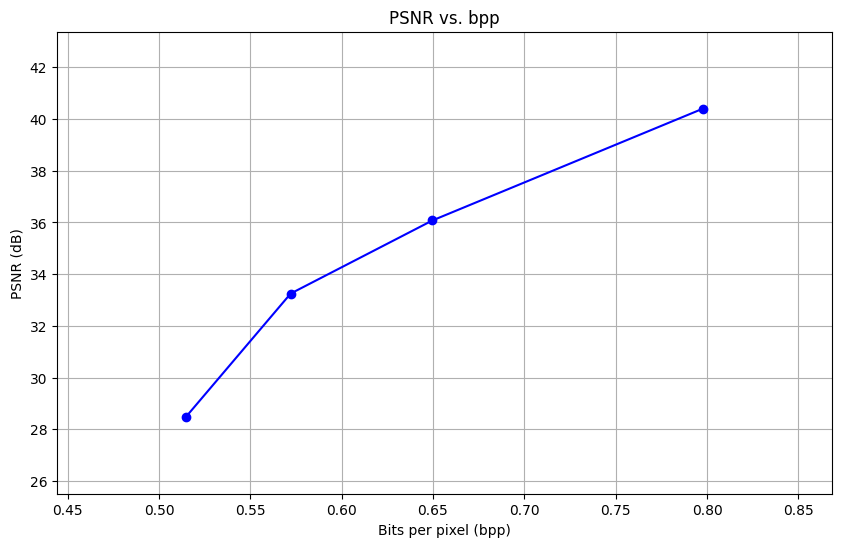

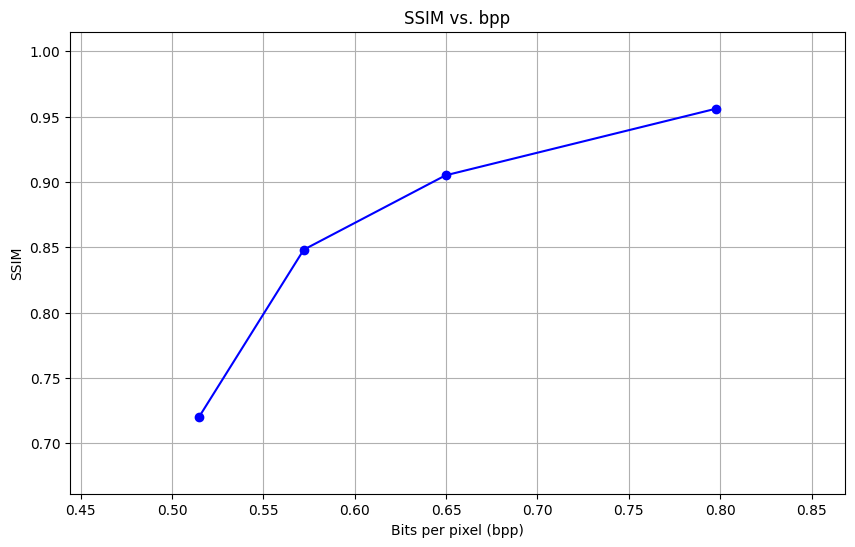

In [70]:
bpp_scale = (max(bpp_list) - min(bpp_list))/4
bpp_lim = (min(bpp_list)-bpp_scale, max(bpp_list)+bpp_scale)

psnr_scale = (max(psnr_list) - min(psnr_list))/4
psnr_lim = (min(psnr_list)-psnr_scale, max(psnr_list)+psnr_scale)

ssim_scale = (max(ssim_list) - min(ssim_list))/4
ssim_lim = (min(ssim_list)-ssim_scale, max(ssim_list)+ssim_scale)

draw_psnr(psnr_list, bpp_list, xlim=bpp_lim, ylim=psnr_lim)
draw_ssim(ssim_list, bpp_list, xlim=bpp_lim, ylim=ssim_lim)


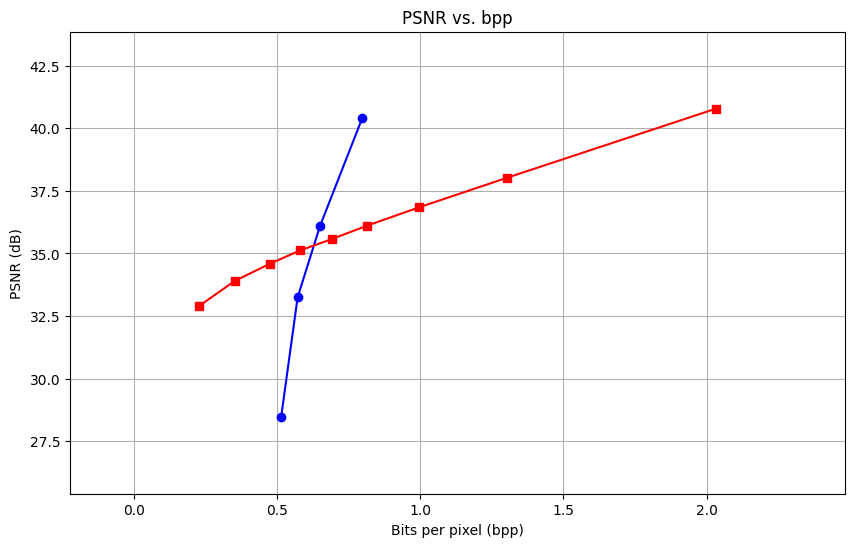

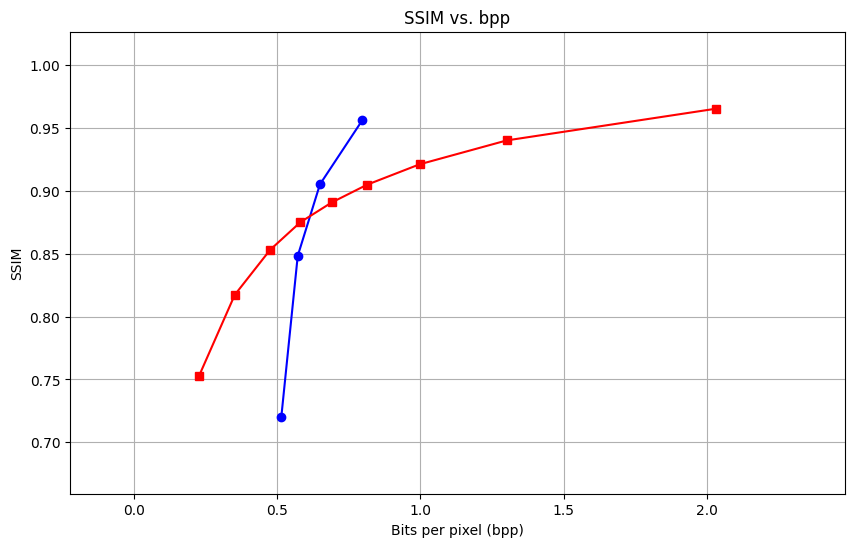

In [72]:
merge_bpp = bpp_list + jpeg_bpp_list
bpp_scale = (max(merge_bpp) - min(merge_bpp))/4
bpp_lim = (min(merge_bpp)-bpp_scale, max(merge_bpp)+bpp_scale)

merge_psnr = psnr_list + jpeg_psnr_list
psnr_scale = (max(merge_psnr) - min(merge_psnr))/4
psnr_lim = (min(merge_psnr)-psnr_scale, max(merge_psnr)+psnr_scale)

merge_ssim = ssim_list + jpeg_ssim_list
ssim_scale = (max(merge_ssim) - min(merge_ssim))/4
ssim_lim = (min(merge_ssim)-ssim_scale, max(merge_ssim)+ssim_scale)

draw_psnr(psnr_list, bpp_list, jpeg_psnr_list, jpeg_bpp_list, xlim=bpp_lim, ylim=psnr_lim)
draw_ssim(ssim_list, bpp_list, jpeg_ssim_list, jpeg_bpp_list, xlim=bpp_lim, ylim=ssim_lim)
